# 08. Vision Transformer

Reference Video: https://www.udemy.com/course/pytorch-for-deep-learning/learn/lecture/33975292#overview

Reference Book: https://www.learnpytorch.io/08_pytorch_paper_replicating/

Extra curricular Reference: [Making Deep Learning Go Brrrr From First Principles](https://horace.io/brrr_intro.html)

In [10]:
import torch
import torchvision

print(f"torch version: {torch.__version__}")
print(f"torchvision version: {torchvision.__version__}")

torch version: 2.0.1+cu117
torchvision version: 0.15.2+cu117


In [11]:
import matplotlib.pyplot as plt
from torchinfo import summary
from going_modular import data_setup, engine, utils
from helper_functions import set_seeds

/home/kpatel2s/miniconda3/envs/pytorch_practice/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [12]:
# device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"device: {device}")

device: cuda


In [13]:
from pathlib import Path

# Setup path to data folder
data_path = Path("data/")
image_path = data_path / "pizza_steak_sushi"

# Setup train and testing paths
train_dir = image_path / "train"
test_dir = image_path / "test"

train_dir, test_dir

(PosixPath('data/pizza_steak_sushi/train'),
 PosixPath('data/pizza_steak_sushi/test'))

### Create data loaders

In [14]:
from torchvision import datasets, transforms
import os
from going_modular import data_setup

IMG_SIZE = 224

manual_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
])

manual_transform

Compose(
    Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=warn)
    ToTensor()
)

In [15]:
NUM_WORKERS = os.cpu_count()
BATCH_SIZE = 32

train_dataloader, test_dataloader, class_names = data_setup.create_dataloaders(train_dir=train_dir,
                                                                                test_dir=test_dir,
                                                                                transform=manual_transform,
                                                                                batch_size=BATCH_SIZE,
                                                                                num_workers=NUM_WORKERS)

print(f"train_dataloader: {train_dataloader}")
print(f"test_dataloader: {test_dataloader}")
print(f"class_names: {class_names}")

Train data:
Dataset ImageFolder
    Number of datapoints: 225
    Root location: data/pizza_steak_sushi/train
    StandardTransform
Transform: Compose(
               Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=warn)
               ToTensor()
           )
Test data:
Dataset ImageFolder
    Number of datapoints: 75
    Root location: data/pizza_steak_sushi/test
    StandardTransform
Transform: Compose(
               Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=warn)
               ToTensor()
           )
train_dataloader: <torch.utils.data.dataloader.DataLoader object at 0x7fa7528342d0>
test_dataloader: <torch.utils.data.dataloader.DataLoader object at 0x7fa752e68050>
class_names: ['pizza', 'steak', 'sushi']


### Sample from a dataset

img.shape: torch.Size([3, 224, 224]), label: 0


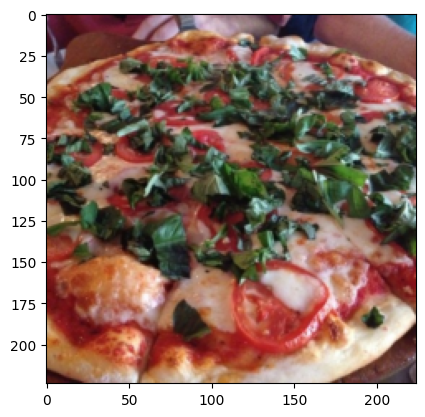

In [25]:
# import random
# # Visualize random 9 images in 3x3 grid
# for i in range(9):
#     plt.subplot(3, 3, i+1)
#     idx = random.randint(0, len(train_dataloader.dataset))
#     plt.imshow(train_dataloader.dataset[idx][0].permute(1, 2, 0))
#     plt.title(f"Label: {class_names[train_dataloader.dataset[idx][1]]}")
#     plt.axis("off")

# get a single image
img_batch, label_batch = next(iter(train_dataloader))
img, label = img_batch[0], label_batch[0]
print(f"img.shape: {img.shape}, label: {label}")

# visualize
img = img.permute(1, 2, 0)
plt.imshow(img)


### Replicating ViT: Overview

- Inputs - Here, image
- Outputs - classification label
- Layers - manipulate with functions
- Blocks - collection of layers
- Models - collection of blocks

### ViT Figures and Equations

#### Main Figure
<img src="https://github.com/mrdbourke/pytorch-deep-learning/blob/main/images/08-vit-paper-figure-1-architecture-overview.png?raw=true" width="900">
<br></br>

#### Four Equations

<img src="https://github.com/mrdbourke/pytorch-deep-learning/blob/main/images/08-vit-paper-four-equations.png?raw=true" width="900">
<br></br>

#### Table

<img src="https://github.com/mrdbourke/pytorch-deep-learning/blob/main/images/08-vit-paper-table-1.png?raw=true" width="900">

### Equation 1 - Convert image to patches

- Input shape: $H \times W \times C$ (height $\times$ width $\times$ color channels)
- Output shape: $N \times\left(P^2 \cdot C\right)$
- $\mathrm{H}=$ height
- $\mathrm{W}=$ width
- $\mathrm{C}=$ color channels
- $\mathrm{P}=$ patch size
- $\mathrm{N}=$ number of patches $=\left(\right.$ height ${ }^*$ width $) / \mathrm{p}^{\wedge} 2$
- $\mathrm{D}=$ constant latent vector size $=$ embedding dimension (see Table 1)


In [27]:
height, width, channels = 224, 224, 3
patch_size = 16

# Number of patches
num_patches = int(height * width / patch_size ** 2)
num_patches

196

In [29]:
embedding_layer_input_shape = (height, width, channels)

embedding_layer_output_shape = (num_patches, patch_size ** 2 * channels)

print(f"embedding_later_input_shape (single 2D image): {embedding_layer_input_shape}")
print(f"embedding_later_output_shape (single 1D sequence of patches): {embedding_layer_output_shape}")

embedding_later_input_shape (single 2D image): (224, 224, 3)
embedding_later_output_shape (single 1D sequence of patches): (196, 768)


torch.Size([224, 224, 3])

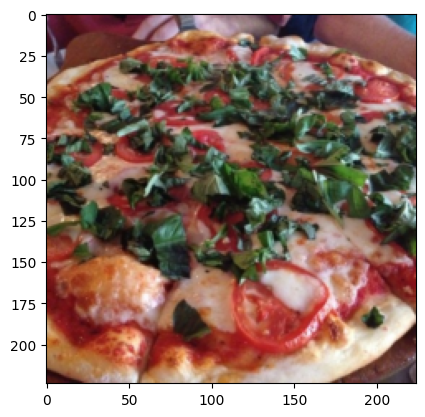

In [32]:
plt.imshow(img)
img.shape

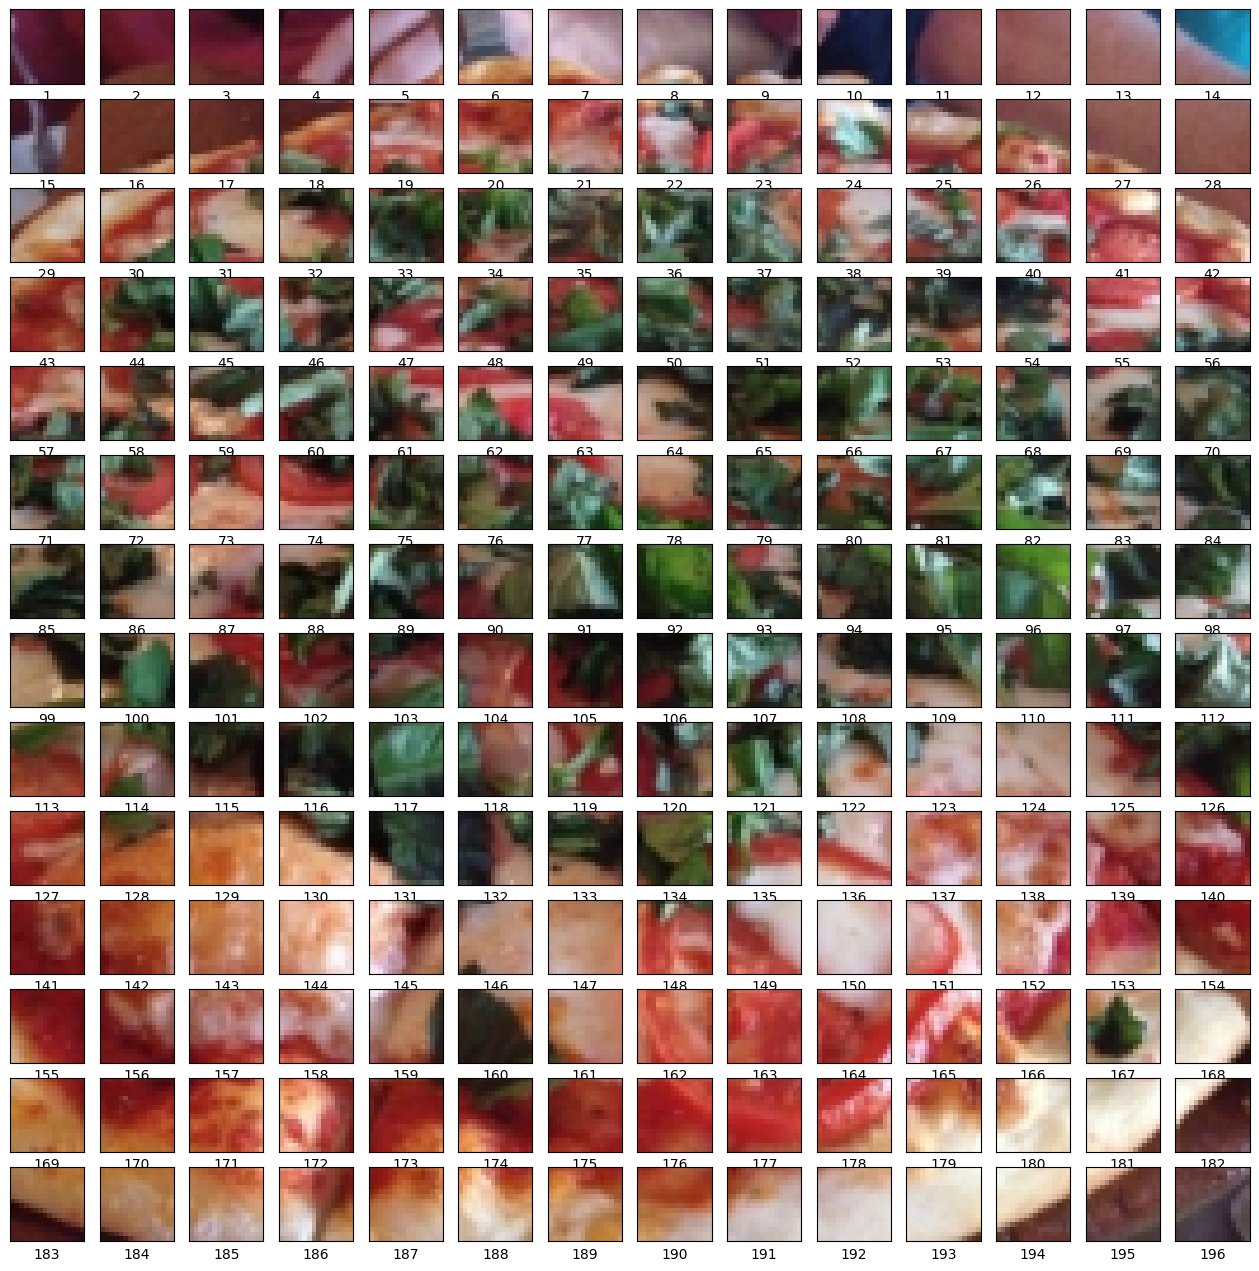

In [46]:
# Image must be divisible by patch size

img_size = 224

fig, axes = plt.subplots(nrows = int(img_size/patch_size),
                         ncols = int(img_size/patch_size),
                         sharex=True,
                         sharey=True,
                         figsize=(patch_size, patch_size))

for i, patch in enumerate(range(0, img_size, patch_size)):
    for j, patch in enumerate(range(0, img_size, patch_size)):
        axes[i][j].imshow(img[i*patch_size:(i+1)*patch_size, j*patch_size:(j+1)*patch_size, :])
        axes[i][j].set_xlabel(i * int(img_size/patch_size) + j+1)
        axes[i][j].set_xticks([])
        axes[i][j].set_yticks([])

- ##### Perhaps we could create the image patches and image patch embeddings in a single step using `torch.nn.Conv2d()` and setting the kernel size and stride parameters to `patch_size`.

In [47]:
from torch import nn

conv2d = nn.Conv2d(in_channels=3,
                   out_channels=patch_size ** 2 * channels, # N^2 * C
                   kernel_size=patch_size,
                   stride=patch_size,
                   padding=0) 
conv2d

Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))

In [52]:
# Pass the image through the convolutional layer
img_permuted = img.permute(2, 0, 1)
img_out_of_conv = conv2d(img_permuted.unsqueeze(0))
print(f"img_out_of_conv.shape: {img_out_of_conv.shape}")

img_out_of_conv.shape: torch.Size([1, 768, 14, 14])


### Visualize feature maps

Showing random convolutional feature maps from indexes: [99, 495, 523, 391, 295]


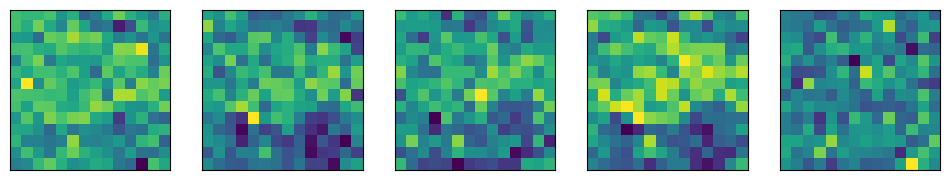

In [56]:
# plot random convolutional feature maps (embeddings)
import random
import numpy as np
random_indexes = random.sample(range(0, 758), k=5)
print(f"Showing random convolutional feature maps from indexes: {random_indexes}")

# Create plot 
fig, axs = plt.subplots(nrows=1, ncols=5, figsize=(12, 12))

# Plot random image feature maps
for i, idx in enumerate(random_indexes):
  image_conv_feature_map = img_out_of_conv[:, idx, :, :] # index on the output tensor of the conv2d layer
  axs[i].imshow(image_conv_feature_map.squeeze().detach().numpy()) # remove batch dimension, and remove from grad tracking/switch to numpy for matplotlib
  axs[i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])

In [60]:
# Flatten the patch embeddings using nn.Flatten
flatten = nn.Flatten(start_dim=2)
img_patches_flattened = flatten(img_out_of_conv)
print(f"img_patches_flattened.shape: {img_patches_flattened.shape}")

img_patches_flattened.shape: torch.Size([1, 768, 196])


In [63]:
print(f"img_patches_flattened (batch_size, num_patches, embedding dimension): {img_patches_flattened.permute(0, 2, 1).shape}")

img_patches_flattened (batch_size, num_patches, embedding dimension): torch.Size([1, 196, 768])


### Patch embedding as single code block

In [113]:
class PatchEmbedding(nn.Module):
    def __init__(self, input_channels, embedding_size, patch_size):
        super().__init__()
        self.input_channels = input_channels
        self.embedding_size = embedding_size
        self.patch_size = patch_size
        self.projection = nn.Conv2d(in_channels=self.input_channels,
                                    out_channels=self.embedding_size,
                                    kernel_size=self.patch_size,
                                    stride=self.patch_size)
        
        self.flatten = nn.Flatten(start_dim=2)

    def forward(self, x):
        image_resolution = x.shape[-1]
        assert image_resolution % self.patch_size == 0, f"Image resolution must be divisible by patch size"
        x = self.projection(x)
        x = self.flatten(x)
        return x.permute(0, 2, 1) # (batch_size, num_patches, embedding dimension)
    
embedding_layer = PatchEmbedding(input_channels=img.shape[-1],
                                 embedding_size=embedding_layer_output_shape[1],
                                 patch_size=patch_size)
embedding_layer

PatchEmbedding(
  (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
  (flatten): Flatten(start_dim=2, end_dim=-1)
)

In [114]:
print(f"Image shape: {img_permuted.unsqueeze(0).shape}")
patch_embedding = embedding_layer(img_permuted.unsqueeze(0))
print(f"patch_embedding.shape: {patch_embedding.shape}")



Image shape: torch.Size([1, 3, 224, 224])
patch_embedding.shape: torch.Size([1, 196, 768])


### Add a learnable class embedding

In [86]:
batch_size = patch_embedding.shape[0]
embedding_dimension = patch_embedding.shape[2]
print(f"batch_size: {batch_size}, embedding_dimension: {embedding_dimension}")


batch_size: 1, embedding_dimension: 768


In [89]:
# Class token as a trainable parameter, so we are using nn.Parameter
class_token = nn.Parameter(torch.randn(batch_size, 1, embedding_dimension),
                           requires_grad=True)
print(f"class_token.shape: {class_token.shape}")

class_token.shape: torch.Size([1, 1, 768])


In [90]:
# Add class token to the front of the patch embeddings
patch_embedding_with_class_token = torch.cat((class_token, patch_embedding), dim=1)
print(f"patch_embedding_with_class_token.shape: {patch_embedding_with_class_token.shape}")

patch_embedding_with_class_token.shape: torch.Size([1, 197, 768])


### Add positional embedding (learnable)

In [96]:
positional_embedding = nn.Parameter(torch.randn(1, num_patches+1, embedding_dimension),
                                    requires_grad=True)

# Add patch embeddings to positional embedding
patch_and_positional_embedding = patch_embedding_with_class_token + positional_embedding

print(f"patch_and_positional_embedding.shape: {patch_and_positional_embedding.shape}")
# NOTE: the shape remains the same as we are adding not concatenating, but values are changed

patch_and_positional_embedding.shape: torch.Size([1, 197, 768])


### Put everything together
Image -> Embeddings

In [104]:
set_seeds(seed=42)

patch_size = 16

print('Image shape: ', img.permute(2, 1, 0).shape)

# Add batch dimension
x = img.permute(2, 1, 0).unsqueeze(0)
print('Input image shape: ', x.shape)

# Patch embedding
patch_embedding_layer = PatchEmbedding(input_channels=x.shape[1],
                                        embedding_size=patch_size ** 2 * x.shape[1],
                                        patch_size=patch_size)

patch_embedding = patch_embedding_layer(x)
print('Patch embedding shape: ', patch_embedding.shape)

# Add class token
class_token = nn.Parameter(torch.randn(batch_size, 1, patch_embedding.shape[-1]),
                           requires_grad=True)

print('Class token shape: ', class_token.shape)

patch_embedding_with_class_token = torch.cat((class_token, patch_embedding), dim=1)
print('Patch embedding with class token shape: ', patch_embedding_with_class_token.shape)

# Add positional embedding
positional_embedding = nn.Parameter(torch.randn(1, num_patches+1, patch_embedding.shape[-1]),
                                    requires_grad=True)

patch_and_positional_embedding = patch_embedding_with_class_token + positional_embedding
print('Patch and positional embedding shape: ', patch_and_positional_embedding.shape)

Image shape:  torch.Size([3, 224, 224])
Input image shape:  torch.Size([1, 3, 224, 224])
Patch embedding shape:  torch.Size([1, 196, 768])
Class token shape:  torch.Size([1, 1, 768])
Patch embedding with class token shape:  torch.Size([1, 197, 768])
Patch and positional embedding shape:  torch.Size([1, 197, 768])


### Put everything together in a single class

In [120]:
class ImageEmbedding(nn.Module):
    def __init__(self, input_channels, embedding_size, patch_size):
        super().__init__()
        self.input_channels = input_channels
        self.embedding_size = embedding_size
        self.patch_size = patch_size
        self.batch_size = 1
        self.projection = nn.Conv2d(in_channels=self.input_channels,
                                    out_channels=self.embedding_size,
                                    kernel_size=self.patch_size,
                                    stride=self.patch_size)
        
        self.flatten = nn.Flatten(start_dim=2)

        

    def add_positional_embedding(self, x):
        # Add positional embedding
        positional_embedding = nn.Parameter(torch.randn(1, num_patches+1, self.embedding_size),
                                            requires_grad=True)
        patch_and_positional_embedding = x + positional_embedding
        return patch_and_positional_embedding

    def add_class_token(self, x):
        # Add class token
        class_token = nn.Parameter(torch.randn(self.batch_size, 1, self.embedding_size),
                                requires_grad=True)
        patch_embedding_with_class_token = torch.cat((class_token, x), dim=1)
        return patch_embedding_with_class_token

    def forward(self, x):
        image_resolution = x.shape[-1]
        assert image_resolution % self.patch_size == 0, f"Image resolution must be divisible by patch size"
        x = self.projection(x)
        x = self.flatten(x)
        x = x.permute(0, 2, 1) # (batch_size, num_patches, embedding dimension)

        x = self.add_class_token(x)

        x = self.add_positional_embedding(x)

        return x
    
embedding_layer = ImageEmbedding(input_channels=img.shape[-1],
                                 embedding_size=embedding_layer_output_shape[1],
                                 patch_size=patch_size)
embedding_layer

ImageEmbedding(
  (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
  (flatten): Flatten(start_dim=2, end_dim=-1)
)

In [121]:
# Add batch dimension
x = img.permute(2, 1, 0).unsqueeze(0)
print('Input image shape: ', x.shape)

# Image to embedding
embeddings = ImageEmbedding(input_channels=x.shape[1],
                                        embedding_size=patch_size ** 2 * x.shape[1],
                                        patch_size=patch_size)
img_embeddings = embeddings(x)
print('Image embeddings shape: ', img_embeddings.shape)

Input image shape:  torch.Size([1, 3, 224, 224])
Image embeddings shape:  torch.Size([1, 197, 768])
